In [1]:
import matplotlib.pyplot as plt
import requests
import numpy as np
import pandas as pd
import pandas_ta as ta
from datetime import datetime
from binance.client import Client

# Initialize the Binance client
client = Client(tld='us')

In [2]:
startDate = '2022-01-01 00:00:00'
testDate  = '2024-06-01 00:00:00'
r = client.get_historical_klines('DOGEUSDT','1h',startDate)

In [3]:
df = pd.DataFrame(r)
colnames = ['openTime','openPrice','highPrice','lowPrice','closePrice','volume','closeTime','quoteAssetVolume','NumberOfTrades','TakerBaseVolume','TakerQuoteVolume','Ignore']
df.columns = colnames
df['closeTime'] = pd.to_datetime(df['closeTime'], unit='ms')
df = df.astype({'closePrice':'float','openPrice':'float','highPrice':'float','lowPrice':'float','volume':'float'})
df['return'] = df['closePrice'].pct_change()
df['return_next'] = df['return'].shift(-1).fillna(0)
df['predict'] = 1
df.set_index("closeTime", inplace= True)
df.head(2)

,openTime,openPrice,highPrice,lowPrice,closePrice,volume,quoteAssetVolume,NumberOfTrades,TakerBaseVolume,TakerQuoteVolume,Ignore,return,return_next,predict
closeTime,,,,,,,,,,,,,,
2022-01-01 00:59:59.999,1640995200000,0.170215,0.172034,0.169855,0.171798,194267.0,33238.21036430,68,117747.00000000,20115.55464420,0,NaN,-0.000497,1
2022-01-01 01:59:59.999,1640998800000,0.171831,0.172800,0.171536,0.171712,452778.0,77889.45000410,72,232479.00000000,39981.18979350,0,-0.000497,-0.001320,1


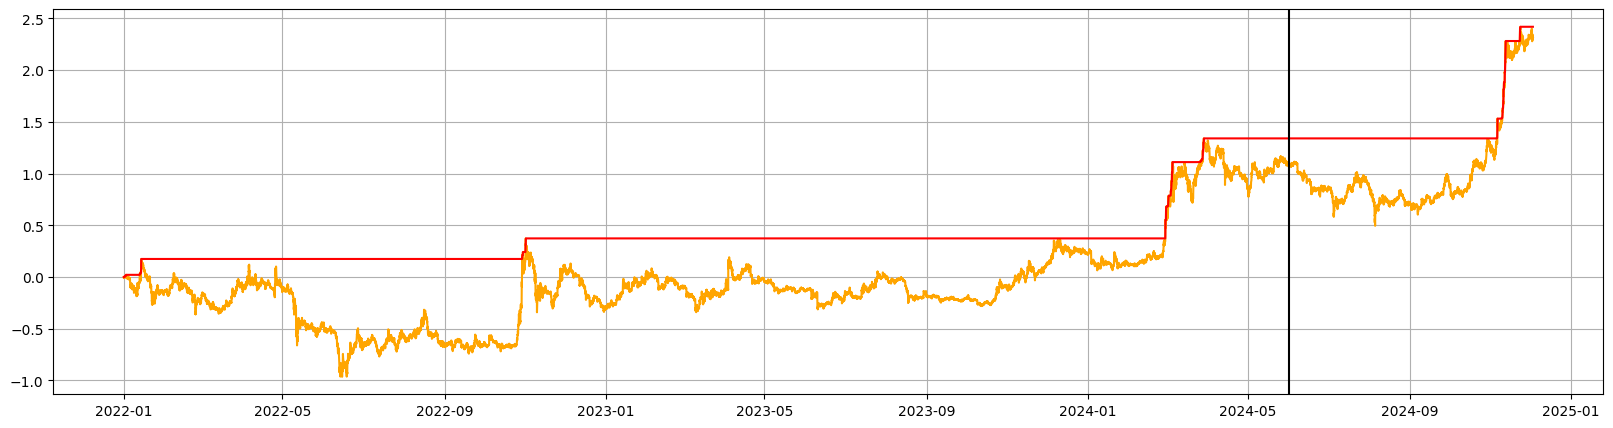

In [4]:
def func_plot(df):
  df['pnl'] = df['return_next'] * df['predict']
  df['pnl_cumsum'] = df['pnl'].cumsum()
  df['pnl_cumsum_max'] = df['pnl_cumsum'].cummax()
  df['pnl_dd'] = df['pnl_cumsum_max'] - df['pnl_cumsum']
  plt.figure(figsize=(20,5))
  plt.plot(df['pnl_cumsum'],color='orange')
  plt.plot(df['pnl_cumsum_max'],color='red')
  plt.axvline(x = pd.to_datetime(testDate), color='black')
  plt.grid()
  plt.show()

func_plot(df)

In [5]:
def func_model_performance(df):
  train = df[(df.index<testDate)].reindex()
  test = df[(df.index>=testDate)].reindex()

  pnl_train = round(train['pnl'].sum(),6)
  pnl_test = round(test['pnl'].sum(),6)

  mdd_train = round(train['pnl_dd'].max(),6)
  mdd_test = round(test['pnl_dd'].max(),6)

  sharpe_train = round(pnl_train/mdd_train,6)
  sharpe_test = round(pnl_test/mdd_test,6)

  print('            train     test')
  print('PNL      : {0: <10}'.format(pnl_train),'{0: <10}'.format(pnl_test))
  print('MDD      : {0: <10}'.format(mdd_train),'{0: <10}'.format(mdd_test))
  print('Sharpe      : {0: <10}'.format(sharpe_train),'{0: <10}'.format(sharpe_test))
  return sharpe_train

In [6]:
help(ta.macd)

Help on function macd in module pandas_ta.momentum.macd:

macd(close, fast=None, slow=None, signal=None, talib=None, offset=None, **kwargs)
    Moving Average Convergence Divergence (MACD)

    The MACD is a popular indicator to that is used to identify a security's trend.
    While APO and MACD are the same calculation, MACD also returns two more series
    called Signal and Histogram. The Signal is an EMA of MACD and the Histogram is
    the difference of MACD and Signal.

    Sources:
        https://www.tradingview.com/wiki/MACD_(Moving_Average_Convergence/Divergence)
        AS Mode: https://tr.tradingview.com/script/YFlKXHnP/

    Calculation:
        Default Inputs:
            fast=12, slow=26, signal=9
        EMA = Exponential Moving Average
        MACD = EMA(close, fast) - EMA(close, slow)
        Signal = EMA(MACD, signal)
        Histogram = MACD - Signal

        if asmode:
            MACD = MACD - Signal
            Signal = EMA(MACD, signal)
            Histogram = MA

In [7]:
df.ta(kind='MACD',append=True,centered=False,high='highPrice',low='lowPrice',volume='volume',close='closePrice',length=6)

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
closeTime,,,
2022-01-01 00:59:59.999,NaN,NaN,NaN
2022-01-01 01:59:59.999,NaN,NaN,NaN
2022-01-01 02:59:59.999,NaN,NaN,NaN
2022-01-01 03:59:59.999,NaN,NaN,NaN
2022-01-01 04:59:59.999,NaN,NaN,NaN
...,...,...,...
2024-12-02 18:59:59.999,-0.003848,-0.000727,-0.003121
2024-12-02 19:59:59.999,-0.003295,-0.000140,-0.003156
2024-12-02 20:59:59.999,-0.003046,0.000088,-0.003134


In [8]:
def func_features(df):

  for length in [6,12,16,20,25,30,50]:
    df.ta(kind='SMA',append=True,centered=False,close='closePrice',length=length)
    df[f'f_SMA_{length}'] = np.where(df['closePrice']>df[f'SMA_{length}'],-1,1)

    df[f'f_trend_{length}'] = np.where(df['return'].rolling(window=length).sum()>0,-1,1)

    df.ta(kind='ATR',append=True,centered=False,high='highPrice',low='lowPrice',volume='volume',close='closePrice',length=length)
    df[f'f_ATR_{length}'] = np.where(df[f'ATRr_{length}']>df[f'ATRr_{length}'].rolling(window=6).sum(),1,-1)

    df.ta(kind='RSI',append=True,centered=False,close='closePrice',length=length)
    df['f_rsi'] = np.where(df[f'RSI_{length}']<20,1,np.where(df[f'RSI_{length}']>80,-1,0))

    df.ta(kind='PVT',append=True,centered=False,volume='volume',close='closePrice')
    df['f_pvt'] = np.where(df['PVT']>df['PVT'].rolling(window=length).mean(),1,-1)

  #df.ta(kind='RSI',append=True,centered=False,close='closePrice',length=length_rsi)
  #df['f_rsi'] = np.where(df[f'RSI_{length_rsi}']<20,1,np.where(df[f'RSI_{length_rsi}']>80,-1,0))

  df.ta(kind='MACD',append=True,centered=False,high='highPrice',low='lowPrice',volume='volume',close='closePrice',length=6)
  df['f_macd'] = np.where(df[f'MACDh_12_26_9']>0,1,-1)

  df.ta(kind='OBV',append=True,centered=False,high='highPrice',low='lowPrice',volume='volume',close='closePrice',length=6)
  df[f'f_OBV'] = np.where(df['OBV']<df['OBV'].rolling(window=12).mean(),-1,1)

  #df.ta(kind='MFI',append=True,centered=False,high='highPrice',low='lowPrice',volume='volume',close='closePrice',length=length)
  #df['f_mfi'] = np.where(df[f'MFI_{length}']<20,1,np.where(df[f'MFI_{length}']>80,-1,0))

  #df['return_next_2'] = np.where(df['return_next'].shift(-11).rolling(window=12).sum()>0,1,-1)
  df['return_next_class'] = np.where(df['return_next']>0,1,0)

  return df
# BTC 'length_rsi': '6', 'length_pvt': '36', 'length_trend': '18', 'model_type': 'lr'
df = func_features(df)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

def func_train_model(modelType,df,testDate):
  features = [col for col in df if col.startswith('f_')]
  #print(features)
  train = df[(df.index<testDate)].reindex()
  test = df[(df.index>=testDate)].reindex()
  X_train = train[features]
  if modelType == 'lr':
    y_train = train['return_next']
    model = LinearRegression()
    model.fit(X_train,y_train)
  if modelType == 'dt':
    y_train = train['return_next_class']
    model = DecisionTreeClassifier(random_state=0,max_depth=5)
    model.fit(X_train,y_train)

  df['predict'] = model.predict(df[features])
  df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))
  df['pnl'] = df['predict'] * df['return_next']
  df['pnl_cumsum'] = df['pnl'].cumsum()
  df['pnl_cumsum_max'] = df['pnl_cumsum'].cummax()
  df['pnl_dd'] = df['pnl_cumsum_max'] - df['pnl_cumsum']
  return df
df = func_train_model('lr',df,testDate)

In [10]:
sharpe = func_model_performance(df)

            train     test
PNL      : 7.245797   0.7986    
MDD      : 0.67422    0.894421  
Sharpe      : 10.746933  0.892868  


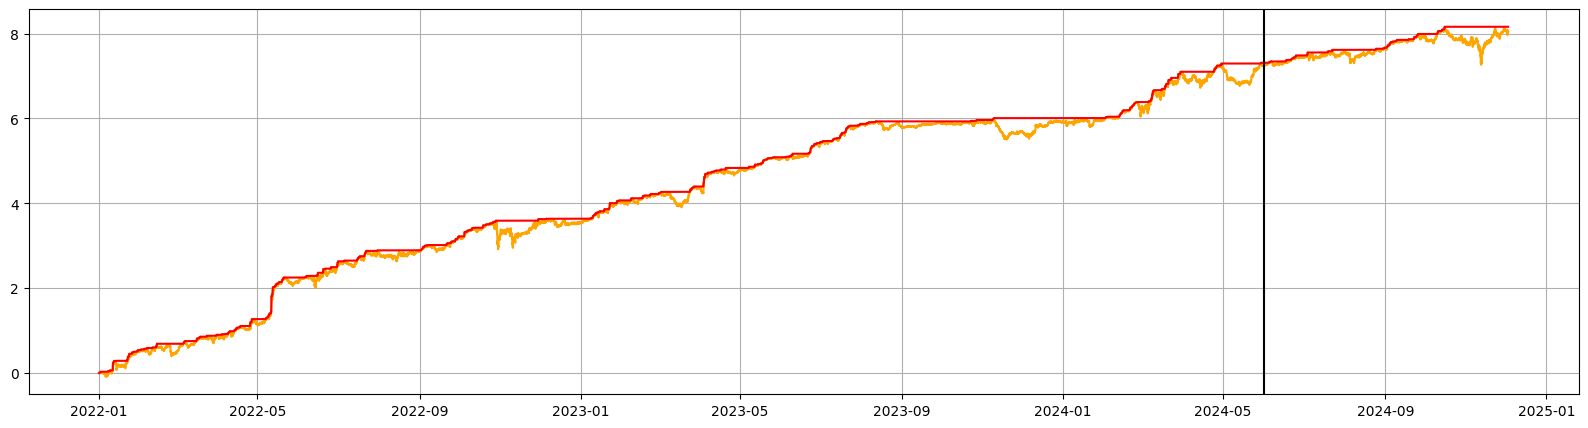

In [11]:
func_plot(df)

In [12]:
import optuna
from functools import partial

def objective(trial, testDate=testDate, df=df):

  #length_rsi = int(trial.suggest_categorical("length_rsi",["6","12","18","24","30","36"]))
  #length_pvt = int(trial.suggest_categorical("length_pvt",["6","12","18","24","30","36"]))
  model_type = trial.suggest_categorical("model_type",["lr","dt"])

  df = func_features(df)
  df = func_train_model(model_type,df,testDate)
  sharpe = func_model_performance(df)

  return sharpe

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 20, timeout = 1000, show_progress_bar = True)

c:\Users\Mirom\Desktop\ML\ml-finance\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-03 01:22:44,403] A new study created in memory with name: no-name-4267d417-59f6-47b1-a1ac-c4f930399e28
Best trial: 0. Best value: 10.7469:   5%|▌         | 1/20 [00:00<00:05,  3.22it/s, 0.31/1000 seconds]

            train     test
PNL      : 7.245797   0.7986    
MDD      : 0.67422    0.894421  
Sharpe      : 10.746933  0.892868  
[I 2024-12-03 01:22:44,713] Trial 0 finished with value: 10.746933 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  10%|█         | 2/20 [00:00<00:05,  3.52it/s, 0.57/1000 seconds]

            train     test
PNL      : 3.220783   0.547667  
MDD      : 0.635732   0.568457  
Sharpe      : 5.066259   0.963427  
[I 2024-12-03 01:22:44,978] Trial 1 finished with value: 5.066259 and parameters: {'model_type': 'dt'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  15%|█▌        | 3/20 [00:00<00:05,  3.37it/s, 0.89/1000 seconds]

            train     test
PNL      : 7.245797   0.7986    
MDD      : 0.67422    0.894421  
Sharpe      : 10.746933  0.892868  
[I 2024-12-03 01:22:45,291] Trial 2 finished with value: 10.746933 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  20%|██        | 4/20 [00:01<00:04,  3.60it/s, 1.14/1000 seconds]

            train     test
PNL      : 3.220783   0.547667  
MDD      : 0.635732   0.568457  
Sharpe      : 5.066259   0.963427  
[I 2024-12-03 01:22:45,540] Trial 3 finished with value: 5.066259 and parameters: {'model_type': 'dt'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  25%|██▌       | 5/20 [00:01<00:04,  3.51it/s, 1.43/1000 seconds]

            train     test
PNL      : 7.245797   0.7986    
MDD      : 0.67422    0.894421  
Sharpe      : 10.746933  0.892868  
[I 2024-12-03 01:22:45,836] Trial 4 finished with value: 10.746933 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  30%|███       | 6/20 [00:01<00:03,  3.58it/s, 1.70/1000 seconds]

            train     test
PNL      : 7.245797   0.7986    
MDD      : 0.67422    0.894421  
Sharpe      : 10.746933  0.892868  
[I 2024-12-03 01:22:46,108] Trial 5 finished with value: 10.746933 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  35%|███▌      | 7/20 [00:01<00:03,  3.59it/s, 1.98/1000 seconds]

            train     test
PNL      : 3.220783   0.547667  
MDD      : 0.635732   0.568457  
Sharpe      : 5.066259   0.963427  
[I 2024-12-03 01:22:46,379] Trial 6 finished with value: 5.066259 and parameters: {'model_type': 'dt'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  40%|████      | 8/20 [00:02<00:03,  3.72it/s, 2.22/1000 seconds]

            train     test
PNL      : 3.220783   0.547667  
MDD      : 0.635732   0.568457  
Sharpe      : 5.066259   0.963427  
[I 2024-12-03 01:22:46,628] Trial 7 finished with value: 5.066259 and parameters: {'model_type': 'dt'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  45%|████▌     | 9/20 [00:02<00:03,  3.65it/s, 2.51/1000 seconds]

            train     test
PNL      : 3.220783   0.547667  
MDD      : 0.635732   0.568457  
Sharpe      : 5.066259   0.963427  
[I 2024-12-03 01:22:46,916] Trial 8 finished with value: 5.066259 and parameters: {'model_type': 'dt'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  50%|█████     | 10/20 [00:02<00:02,  3.72it/s, 2.77/1000 seconds]

            train     test
PNL      : 3.220783   0.547667  
MDD      : 0.635732   0.568457  
Sharpe      : 5.066259   0.963427  
[I 2024-12-03 01:22:47,171] Trial 9 finished with value: 5.066259 and parameters: {'model_type': 'dt'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  55%|█████▌    | 11/20 [00:03<00:02,  3.61it/s, 3.06/1000 seconds]

            train     test
PNL      : 7.245797   0.7986    
MDD      : 0.67422    0.894421  
Sharpe      : 10.746933  0.892868  
[I 2024-12-03 01:22:47,467] Trial 10 finished with value: 10.746933 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  60%|██████    | 12/20 [00:03<00:02,  3.47it/s, 3.38/1000 seconds]

            train     test
PNL      : 7.245797   0.7986    
MDD      : 0.67422    0.894421  
Sharpe      : 10.746933  0.892868  
[I 2024-12-03 01:22:47,781] Trial 11 finished with value: 10.746933 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  65%|██████▌   | 13/20 [00:03<00:02,  3.45it/s, 3.67/1000 seconds]

            train     test
PNL      : 7.245797   0.7986    
MDD      : 0.67422    0.894421  
Sharpe      : 10.746933  0.892868  
[I 2024-12-03 01:22:48,076] Trial 12 finished with value: 10.746933 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  70%|███████   | 14/20 [00:03<00:01,  3.51it/s, 3.94/1000 seconds]

            train     test
PNL      : 7.245797   0.7986    
MDD      : 0.67422    0.894421  
Sharpe      : 10.746933  0.892868  
[I 2024-12-03 01:22:48,349] Trial 13 finished with value: 10.746933 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  75%|███████▌  | 15/20 [00:04<00:01,  3.51it/s, 4.23/1000 seconds]

            train     test
PNL      : 7.245797   0.7986    
MDD      : 0.67422    0.894421  
Sharpe      : 10.746933  0.892868  
[I 2024-12-03 01:22:48,633] Trial 14 finished with value: 10.746933 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  80%|████████  | 16/20 [00:04<00:01,  3.58it/s, 4.50/1000 seconds]

            train     test
PNL      : 7.245797   0.7986    
MDD      : 0.67422    0.894421  
Sharpe      : 10.746933  0.892868  
[I 2024-12-03 01:22:48,903] Trial 15 finished with value: 10.746933 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  85%|████████▌ | 17/20 [00:04<00:00,  3.60it/s, 4.77/1000 seconds]

            train     test
PNL      : 7.245797   0.7986    
MDD      : 0.67422    0.894421  
Sharpe      : 10.746933  0.892868  
[I 2024-12-03 01:22:49,175] Trial 16 finished with value: 10.746933 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  90%|█████████ | 18/20 [00:05<00:00,  3.54it/s, 5.06/1000 seconds]

            train     test
PNL      : 7.245797   0.7986    
MDD      : 0.67422    0.894421  
Sharpe      : 10.746933  0.892868  
[I 2024-12-03 01:22:49,465] Trial 17 finished with value: 10.746933 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469:  95%|█████████▌| 19/20 [00:05<00:00,  3.64it/s, 5.32/1000 seconds]

            train     test
PNL      : 7.245797   0.7986    
MDD      : 0.67422    0.894421  
Sharpe      : 10.746933  0.892868  
[I 2024-12-03 01:22:49,727] Trial 18 finished with value: 10.746933 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 10.746933.


Best trial: 0. Best value: 10.7469: 100%|██████████| 20/20 [00:05<00:00,  3.56it/s, 5.62/1000 seconds]

            train     test
PNL      : 7.245797   0.7986    
MDD      : 0.67422    0.894421  
Sharpe      : 10.746933  0.892868  
[I 2024-12-03 01:22:50,027] Trial 19 finished with value: 10.746933 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 10.746933.
